<a href="https://colab.research.google.com/github/dimtr/PyDataEHV_workshop/blob/master/TextGeneration/Sherlock_PyData.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Text Generation with LSTM
In this workshop, we see how recurrent Neural Networks could be used as Generative Models. They can learn the sequences of a problem and generate entirely new plausible sequences for the problem domain.

We will discover how to create a simple text generation model using Python in [Keras](https://keras.io/) that generates text, word-by-word. We will work with the dataset of Sherlock Holmes's stories retrieved from eBook savailable on Project Gutenberg. 

Given a sequence of words, the model trained on our dataset will predict the next most probable word. We will call the model repeatedly to generate longer sequences.  



##Setup

####Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

####Import Keras and other libraries

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout,SimpleRNN, LSTM, Embedding
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from glob import glob
from tqdm import tqdm

import numpy as np


#### Clone GitHub Repository

In [0]:
!git clone https://github.com/dimtr/PyDataEHV_workshop/

####Reading the data

We take a look at the data

In [0]:
files = glob('/content/PyDataEHV_workshop/TextGeneration/datasets/sherlock/*')
stories = []
for doc in files:
  with open(doc, encoding='utf-8') as f:
    story = f.readlines()
    stories.append(story[4:6]+story[10:-26])

print(''.join(stories[0][:20]))

##Process the Text
Before training the model, we need to process the text in a form that is interpretable by the model.  

#### Story in words

First, we convert the story data into chunks of words or tokens. Since we want our model to also recognize puntuations as words, we use [replace()](https://docs.python.org/2/library/string.html#string.replace) to add white spaces around them and then use [split()](https://docs.python.org/2/library/stdtypes.html#str.split) to split the story into word chunks. 

In [0]:
story_in_words = []
for story in stories:
  temp = []
  for i, line in enumerate(story):
    story[i] = line.lower().replace('.', ' . ').\
                            replace('\n', ' \n ').\
                            replace(',', ' , ').\
                            replace('?', ' ? ').\
                            replace('"',' " ').\
                            replace('!', ' ! ').\
                            replace(':', ' : ').\
                            replace(';', ' ; ').\
                            replace('--', ' ').\
                            replace('-', ' ').\
                            replace(',',' , ')

    temp.extend(story[i].split(' '))
  temp.append('|endofstory|')


  story_in_words.append(list(filter(None, temp))) 



####Creating sequences

The next step is to split the entire text into sequences of a certain length. We specify this length by using the hyper parameter SEQ_LEN. Sequence length is the number of words that the generative model would take as input to predict the next word. 

We go over the story by, shifting by one word at each step and take SEQ_LEN + 1 words in a sequence at a time.

In [0]:
SEQ_LEN = 50
step = 1
sentences = []
for words in story_in_words:
  for i in range(0, len(words) - SEQ_LEN, step):
    sentences.append(words[i: i + SEQ_LEN + 1])


####Tokenizer

Now we need to map the strings to numeric representation. We want each unique word to be represented by a unique integer number. We use the [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class by Keras for this task. The class then calls a function that fits the tokenizer on the our sequences of text and builds an internal vocabulary. 

Note: 0 is a reserved index in this class that won't be assigned to any word.

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)  # transforms each text sequence into a sequence of integer, where each integer represents a unique word
sequences = np.asarray(sequences)                    # converting a list to a numpy array
vocab = tokenizer.word_counts                        # Dict object of vocabulary with frequency count

VOCAB_LEN = len(tokenizer.word_counts) + 1
total = sequences.shape[0]


In [0]:
VOCAB_LEN

16461

### Pre-trained Glove Embedding

The STanford NLP Group developed [GloVe](https://nlp.stanford.edu/projects/glove/), an unsupervised learning algorithm for obtaining vector representations for words. Various pre-train word vectors are available on [here](https://nlp.stanford.edu/projects/glove/). For this workshop, we use the 300 dimension vectors, trained on Wikipedia 2014 and the Fifth Edition of English Gigaword text data, having 6B tokens, 400K vocabulary of uncased words.

The following two code cells demonstrate how to use the pre-trained GloVe embedding as weights for training our Embedding layer. You can uncomment these code lines and try it at home after downloading the word vectors.

In [0]:
'''
embedding_vector = {}
f = open('../input/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

'''

In [0]:
'''
embedding_matrix = np.zeros((VOCAB_LEN,300))
for word,i in tqdm(vocab.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

'''

Due to time constraints, we use a pre computed embedding matrix numpy file which is much smaller in size to skip the embedding matrix creation time.

In [0]:
embedding_matrix = np.load('/content/PyDataEHV_workshop/TextGeneration/emd_matrix.npy')

####Training and Test data split

Data is shuffled and split into training and test dataset with 15% of the data in the test split. 

The first *SEQ_LEN* words of the sequence make the input data and the remaining last word is the target data or the next probable word that the model should output.

In [0]:
sequences = shuffle(sequences)

train_input = sequences[int(total * 0.15):, :-1]
train_output = sequences[int(total * 0.15):, -1]

test_input = sequences[:int(total * 0.15), :-1]
test_output = sequences[:int(total * 0.15), -1]


print("Input Training Data Shape:", train_input.shape)
print("Target Training Data Shape:", train_output.shape)

print("Input Test Data Shape:", test_input.shape)
print("Target Test Data Shape:", test_output.shape)

Input Training Data Shape: (487513, 50)
Target Training Data Shape: (487513,)
Input Test Data Shape: (86031, 50)
Target Test Data Shape: (86031,)


####Build the RNN Model

We use the [Keras Sequential Model](https://keras.io/getting-started/sequential-model-guide/) to define the model. To build our simple RNN text generation model, we use four keras layers:


*   [keras.layers.Embedding](https://keras.io/layers/embeddings/)
*   [keras.layers.SimpleRNN](https://https://keras.io/layers/recurrent/#simplernn)
*   [keras.layers.Dropout](https://keras.io/layers/core/#dropout)
*   [keras.layers.Dense](https://keras.io/layers/core/#dense)



In [0]:
model = Sequential()
model.add(Embedding(VOCAB_LEN, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(VOCAB_LEN, activation='softmax'))

We compile the model to configure it for training and use categorical crossentropy as our loss function. [link text](https://)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 256)           4214016   
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 512)           1574912   
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 256)           787456    
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)              

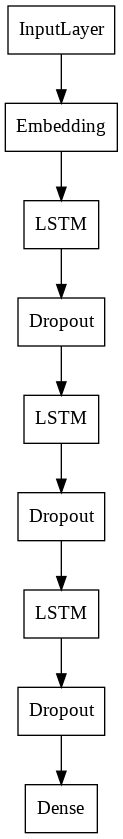

In [0]:
from keras.utils import plot_model
plot_model(model, show_layer_names=False, to_file='/content/PyDataEHV_workshop/TextGeneration/model.png')

###Helper Functions

We create a generator function that generates data batch-by-batch. The generator is run in parallel to the model, for efficiency. 

In [0]:
def generator(sent, word, batch_size):

  global index
  index = 0
  while True:
    x = np.zeros((batch_size, SEQ_LEN), dtype=np.int)
    y = np.zeros((batch_size, VOCAB_LEN), dtype=np.bool)

    for i in range(batch_size):
      x[i] = sent[index % len(sent)]
      y[i] = to_categorical(word[index % len(word)], num_classes=VOCAB_LEN) #convert integers to one-hot encoded vectors
      index = index + 1
    yield x,y

This function samples an index from a softmax probablity array based on the temperature. This technique is called temperature sampling and is used to improve the quality of samples from language models.

Note: The high temperature sample displays greater linguistic variety, but the low temperature sample is more grammatically correct. Lowering the temperature allows you to focus on higher probability output sequences and smooth over deficiencies of the model.

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.flip(np.argsort(probas))[0]

We make a simple display function that prints the stories 

In [0]:
def display(story):
  full = ''
  for word in story:
    if word == '|newline|':
      full = full + '\n'
    elif word in ',.;:?!':
      full = full + word
    else:
      full = full + ' ' + word
  
  print(full)


####Configure Checkpoints

We use two types of checkpoints for our model:


*   [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint): to ensure that checkpoints are saved during training by monitoring a quality (validation accuracy in this case)
*   [EarlyStopping](https://keras.io/callbacks/#EarlyStopping): stops training when the monitored quality (validation accuracy) has not improved for a certain number of epochs. This threshold is set by the *patience* argument.



In [0]:
BATCH_SIZE =32
file_path = "/content/PyDataEHV_workshop/TextGeneration/checkpoints/Sherlock/Sherlock-RNN-epoch{epoch:03d}-words%d-sequence%d-batchsize%d-" \
            "loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}.hdf5" % \
            (VOCAB_LEN, SEQ_LEN, BATCH_SIZE)

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True) # latest best model according to the val_acc monitored will not be overwritten
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callbacks_list = [checkpoint, early_stopping]

Uncomment if you do not want to train the model from scratch.

In [0]:
#model.load_weights('/content/PyDataEHV_workshop/TextGeneration/checkpoints/Sherlock/sherlock-RNN-epoch014-words16461-sequence20-batchsize512-loss4.0425-acc0.2680-val_loss4.2978-val_acc0.2620.hdf5')

####Train the Model

The model is trained for 30 epochs, but training could stop early due to the callback. 

In [0]:
model.fit_generator(generator(train_input, train_output, BATCH_SIZE),
                    steps_per_epoch=int(len(train_input)/BATCH_SIZE) + 1,
                    epochs=30,
                    callbacks=callbacks_list,
                    validation_data=generator(test_input, test_output, BATCH_SIZE),
                    validation_steps=int(len(test_input)/BATCH_SIZE) + 1)

###Generate Text

####Restore the latest checkpoint


In [0]:
#model.load_weights('/content/PyDataEHV_workshop/TextGeneration/checkpoints/Sherlock/sherlock-RNN-epoch014-words16461-sequence20-batchsize512-loss4.0425-acc0.2680-val_loss4.2978-val_acc0.2620.hdf5')

####Conditional Samples

Here, the story is generated word-by-word, based on a prompt provided. If the number of words in the prompt exceed SEQ_LEN, then the prompt is truncated from the beginning to fit the sequence length. If the length of prompt is less than SEQ_LEN, then zeros are padded in the beginning. The whole story is genrated by predicting the next probable word in a loop.

Note: Since 0 is used to pad sequences, it is important that the Tokenizer does not use 0 as an index. 

In [0]:
def generate_cond_samples(no_of_words, temp):
    
    print('Enter prompt: \n')
    seed = input()
    sentence = tokenizer.texts_to_sequences([seed])[0]

    sentence = list(pad_sequences([sentence], maxlen=SEQ_LEN, padding='pre', truncating='pre')[0])


    gen_story = []
    gen_story.extend(seed.split())

    for i in range(no_of_words):
        x_pred = np.expand_dims(sentence, axis=0) 
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_indices = sample(preds, temp)

        for ix in next_indices:
          if ix == 0:
            continue
          else:
            next_word = tokenizer.index_word[ix]
            sentence = sentence[1:]
            sentence.append(ix)
            break

        gen_story.append(next_word)
        
    display(gen_story)
        
       
    

In [0]:
generate_cond_samples(no_of_words = 500, temp=0.5)

Enter prompt: 

Sherlock woke up and saw
 Sherlock woke up and saw him, and then and that he had been seen and at the last time, and the other was a tall, thin, thin, thin, eager face of the house. he had been there, " said holmes. " i have never been a very good man, and his eyes were brought by a very different man, and that he had been taken at the way of a paper, and i am prepared to leave him to be a clue. " 
 
 " yes, i have not no doubt that i should be able to tell me that you have no doubt that it is not a good deal for a clue. " 
 
 " i am sorry, that he had been a perfect knife, and i am sure that i could have been so. he has been seen. i have no doubt that it is a very certain that a very strange man who had been a good deal. " 
 
 " that is a very few minutes of a world, but it was clear that you should be able to learn that you have come out of my own story. " 
 
 " i should not be able to see it. but the man was a fine man. i had a little than i had been a very considera

####Unconditional Samples

Here, the story is generated word-by-word by starting with a random seed. One integer is randomly sampled from the index of words and story is generated by prediciting the next probable work in a loop.

In [0]:
def generate_uncond_samples(no_of_words, temp):
    np.random.seed(0)
    seed = np.random.randint(1, VOCAB_LEN, size=SEQ_LEN)

    sentence = seed

    sentence = list(pad_sequences([sentence], maxlen=SEQ_LEN, padding='pre')[0])

    gen_story = []

    gen_story.extend(tokenizer.index_word[w] for w in seed)
    end_flag = 0

    for i in range(no_of_words):
        x_pred = np.expand_dims(sentence, axis=0)

        preds = model.predict(x_pred, verbose=0)[0]
        next_indices = sample(preds, temp)

        for ix in next_indices:
            if ix == 0:
                continue

            elif '|endofstory|' in tokenizer.word_index.keys():
                if ix == tokenizer.word_index['|endofstory|'] :
                    end_flag = 1
                    break
            else:
                next_word = tokenizer.index_word[ix]
                sentence = sentence[1:]
                sentence.append(ix)
                break

        if end_flag == 1:
            break


        gen_story.append(next_word)

    display(gen_story)

In [0]:
generate_uncond_samples(no_of_words = 500, temp=0.5)

Looking at the generated text, you'll see the model knows when to use punctuations, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.



###Build an LSTM Model

We keep the structure for the model similar but use the Keras LSTM layer instead of the SimpleRNN layer. We again use the [Keras Sequential Model](https://keras.io/getting-started/sequential-model-guide/) to define the LSTM based generative model by using four keras layers:


*   [keras.layers.Embedding](https://keras.io/layers/embeddings/): used to train a dense representation of words and their relative meanings.
*   [keras.layers.LSTM](https://keras.io/layers/recurrent/#lstm): long-short term memory layer composed of a *cell*, an *input gate*, an *output gate* and a *forget gate*.
*   [keras.layers.Dropout](https://keras.io/layers/core/#dropout): applies a regularization technique where randomly selected neurons are ignored or "dropped-out" during training.
*   [keras.layers.Dense](https://keras.io/layers/core/#dense): regular densely connected neural network layer with output size equal to the vocabulary size (number of unique words). This layer is added at the end and uses the softmax activation to output the probablities (that add up to one) for each word. 



In [0]:
lstm_model = Sequential()
lstm_model.add(Embedding(VOCAB_LEN, 256, input_length=SEQ_LEN))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(VOCAB_LEN, activation='softmax'))

We compile the model to configure it for training and use categorical crossentropy as our loss function. 

In [0]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 256)           5127936   
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 128)           197120    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20031)             1302015   
Total params: 6,676,479
Trainable params: 6,676,479
Non-trainable params: 0
____________________________________________

### Configure Checkpoints

In [0]:
BATCH_SIZE =256
file_path = "/content/PyDataEHV_workshop/TextGeneration/checkpoints/Sherlock/Sherlock-LSTM-epoch{epoch:03d}-words%d-sequence%d-batchsize%d-" \
            "loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}.hdf5" % \
            (VOCAB_LEN, SEQ_LEN, BATCH_SIZE)

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc', patience=10)
callbacks_list = [checkpoint, early_stopping]

Uncomment if you do not want to train the model from scratch.

In [0]:
#model.load_weights('/content/PyDataEHV_workshop/TextGeneration/checkpoints/Sherlock/sherlock-LSTM-epoch021-words16461-sequence20-batchsize512-loss3.4346-acc0.3279-val_loss4.4792-val_acc0.2852.hdf5')

###Train the LSTM Model

The model is trained for 30 epochs, but training could stop early due to the callback. 

In [0]:
lstm_model.fit_generator(generator(train_input, train_output, BATCH_SIZE),
                    steps_per_epoch=int(len(train_input)/BATCH_SIZE) + 1,
                    epochs=30,
                    callbacks=callbacks_list,
                    validation_data=generator(test_input, test_output, BATCH_SIZE),
                    validation_steps=int(len(test_input)/BATCH_SIZE) + 1)

Epoch 1/100
2967/2967 [==============================] - 193s 65ms/step - loss: 4.7060 - acc: 0.3779 - val_loss: 4.6633 - val_acc: 0.3739
Epoch 2/100
2967/2967 [==============================] - 193s 65ms/step - loss: 4.6286 - acc: 0.3780 - val_loss: 4.6606 - val_acc: 0.3736
Epoch 3/100
2967/2967 [==============================] - 192s 65ms/step - loss: 4.1183 - acc: 0.4032 - val_loss: 3.6000 - val_acc: 0.4620
Epoch 4/100
2967/2967 [==============================] - 191s 64ms/step - loss: 3.4038 - acc: 0.4760 - val_loss: 3.3236 - val_acc: 0.4872
Epoch 5/100
2967/2967 [==============================] - 191s 64ms/step - loss: 3.1931 - acc: 0.4954 - val_loss: 3.2089 - val_acc: 0.4966
Epoch 6/100
2967/2967 [==============================] - 191s 64ms/step - loss: 3.0667 - acc: 0.5052 - val_loss: 3.1520 - val_acc: 0.5016
Epoch 7/100
2967/2967 [==============================] - 192s 65ms/step - loss: 2.9717 - acc: 0.5126 - val_loss: 3.1142 - val_acc: 0.5065
Epoch 8/100
2967/2967 [===========

###Generate Text 

####Restore the last checkpoint

In [0]:
model.load_weights('/content/PyDataEHV_workshop/TextGeneration/checkpoints/Sherlock/sherlock-LSTM-epoch021-words16461-sequence20-batchsize512-loss3.4346-acc0.3279-val_loss4.4792-val_acc0.2852.hdf5')

####Unconditional Text Generation

Starting from a random seed.

In [0]:
generate_uncond_samples(no_of_words = 500, temp=0.5)

####Conditional Text Generation

Enter a starting prompt.

In [0]:
generate_cond_samples(no_of_words = 500, temp=0.5)